# Présentation du projet IA

## Introduction

Ce notebook présente un projet d'intelligence artificielle appliqué à l'analyse de données AIS. Il illustre différentes techniques telles que le prétraitement, le clustering, la régression et la classification.  
## Structure du Projet

- **Données**: Le dossier `data/` contient le jeu de données d'exemple (`After_Sort_sans_l&w_vide.csv` ou `sample_data.csv`).
- **Code Source**: ce code source traitera du besoin 2 et comprendra :
  - **Clustering**: Regroupement géographique des navires.
  - **Régression**: Prédiction de la vitesse (`SOG`) en fonction de caractéristiques telles que la `Length` et le `Draft`.
  - **Classification**: Prédiction du type d’engin (`VesselType`) en utilisant diverses approches (Random Forest, HistGradientBoostingClassifier).

In [102]:
  
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, confusion_matrix, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer
from sklearn.utils.class_weight import compute_sample_weight

from imblearn.over_sampling import SMOTE
import optuna

VESSEL_TYPES = list(range(60, 90))

## Chargement et Prétraitement des Données

La fonction `load_and_clean_data` s'assure que les données sont correctement chargées et nettoyées, en convertissant notamment la colonne `BaseDateTime` en datetime et en convertissant la colonne `VesselType` en numérique.  
Le prétraitement est ensuite enrichi par la fonction `preprocess_df` qui effectue :
- La déduplication des colonnes.
- Le tri des données par `MMSI` et `BaseDateTime`.
- La création de nouvelles features telles que :
  - `dt`: délais entre observations.
  - `dx` et `dy`: différences spatiales.
  - `speed_calc`: vitesse calculée à partir des différences spatiales et temporelles.
  - `accel`: accélération.
  - `dist_to_port`: distance au port principal (exemple: Houston).


In [103]:

def load_and_clean_data(path: str) -> pd.DataFrame:
    df = pd.read_csv(path, parse_dates=['BaseDateTime'])
    df['VesselType'] = pd.to_numeric(df['VesselType'], errors='coerce')
    return df

    # Set the CSV file path
filepath = r"c:\Users\Utilisateur\Documents\GitHub\Projet_Outil_de_l-ing-_S6\IA\After_Sort_sans_l&w_vide.csv"
    
    # Load and clean the data
df = load_and_clean_data(filepath)
print("Rows loaded:", len(df))

Rows loaded: 371215


## Analyse de Clustering

Le module de clustering vise à segmenter les navires en fonction de leur position géographique.  
La fonction `perform_clustering` réalise les étapes suivantes :
- Filtrage des navires en se basant sur leur vitesse (`SOG` > 1 noeud) et sur un sous-ensemble de types (`VESSEL_TYPES`).
- Visualisation des positions via un nuage de points.
- Application de l’algorithme K-means pour identifier des clusters et afficher les centres de ces clusters.



--- Clustering ---


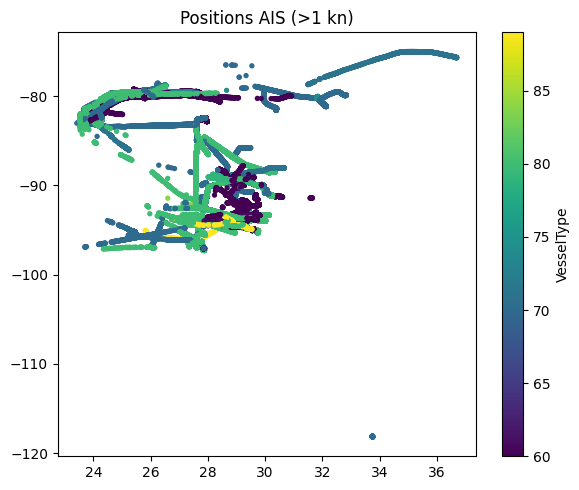

Cluster centers: [[ 29.18391529 -89.71606919]
 [ 26.44696796 -80.62489952]
 [ 28.74444558 -94.40980194]]


In [104]:


def perform_clustering(df: pd.DataFrame) -> None:
    # Filtrage sur la vitesse et sur les VesselType entre 60 et 89
    filtered = df[(df['VesselType'].isin(VESSEL_TYPES)) & (df['SOG'] > 1)].copy()
    plt.figure(figsize=(6,5))
    scatter = plt.scatter(filtered['LAT'], filtered['LON'],
                          c=filtered['VesselType'], cmap='viridis', s=8)
    plt.title('Positions AIS (>1 kn)')
    plt.colorbar(scatter, ticks=VESSEL_TYPES[::5], label='VesselType')
    plt.tight_layout(); plt.show()

    kmeans = KMeans(n_clusters=3, random_state=42)
    filtered['Cluster'] = kmeans.fit_predict(filtered[['LAT','LON']])
    print("Cluster centers:", kmeans.cluster_centers_)
    # Run clustering (only on ships with non-zero SOG)
print("\n--- Clustering ---")
perform_clustering(df)



## Analyse de Régression

L'analyse de régression est appliquée pour prédire la vitesse (`SOG`) en fonction de caractéristiques comme la `Length` et le `Draft`.  
Pour chaque type d’engin (80, 60, 70), la fonction `regress_speed` :
- Sélectionne un sous-ensemble de données.
- Sépare les données en ensembles d'entraînement et de test.
- Entraîne plusieurs modèles (régression linéaire, Random Forest, Gradient Boosting).
- Évalue et compare les modèles via des métriques comme RMSE, MAE et R².
- Sauvegarde le modèle le plus performant.


In [105]:

def regress_speed(df: pd.DataFrame) -> None:
    for vt in VESSEL_TYPES:
        subset = df[(df['VesselType']==vt)].dropna(subset=['SOG','Length','Draft'])
        if len(subset) < 40:
            print(f"❕ VT {vt}: jeux insuffisant ({len(subset)})")
            continue

        X = subset[['Length','Draft']]
        y = subset['SOG']
        X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=.3, random_state=42)

        MODELS = {
            'LinReg' : LinearRegression(),
            'RF'     : RandomForestRegressor(n_estimators=300, random_state=42),
            'GBR'    : GradientBoostingRegressor(random_state=42)
        }

        print(f"\n=== Régression VT {vt} ===")
        best_rmse, best_tag = 1e9, None
        for tag, model in MODELS.items():
            model.fit(X_tr, y_tr)
            preds = model.predict(X_te)

            mse  = mean_squared_error(y_te, preds)   # <─ plus de « squared=False »
            rmse = np.sqrt(mse)
            mae  = mean_absolute_error(y_te, preds)
            r2   = r2_score(y_te, preds)
            print(f"{tag:6s} | RMSE {rmse:5.2f} | MAE {mae:5.2f} | R²={r2:.2f}")
            if rmse < best_rmse:
                best_rmse, best_tag, best_model = rmse, tag, model

        joblib.dump(best_model, f"best_reg_VT{vt}_{best_tag}.pkl")
        print(f"➜ Modèle {best_tag} sauvegardé → best_reg_VT{vt}_{best_tag}.pkl")

            
    # Run regression tests for each VesselType (80, 60, 70)
print("\n--- Regression ---")
regress_speed(df)
    





--- Regression ---

=== Régression VT 60 ===
LinReg | RMSE 28.52 | MAE 16.86 | R²=0.00
RF     | RMSE  4.67 | MAE  3.02 | R²=0.97
GBR    | RMSE  4.67 | MAE  3.03 | R²=0.97
➜ Modèle RF sauvegardé → best_reg_VT60_RF.pkl

=== Régression VT 61 ===
LinReg | RMSE  8.50 | MAE  8.31 | R²=-0.00
RF     | RMSE  8.49 | MAE  8.31 | R²=-0.00
GBR    | RMSE  8.50 | MAE  8.31 | R²=-0.00
➜ Modèle RF sauvegardé → best_reg_VT61_RF.pkl
❕ VT 62: jeux insuffisant (0)
❕ VT 63: jeux insuffisant (0)
❕ VT 64: jeux insuffisant (0)
❕ VT 65: jeux insuffisant (0)
❕ VT 66: jeux insuffisant (0)
❕ VT 67: jeux insuffisant (0)
❕ VT 68: jeux insuffisant (0)

=== Régression VT 69 ===
LinReg | RMSE  1.21 | MAE  0.38 | R²=0.64
RF     | RMSE  1.21 | MAE  0.38 | R²=0.64
GBR    | RMSE  1.21 | MAE  0.38 | R²=0.64
➜ Modèle LinReg sauvegardé → best_reg_VT69_LinReg.pkl

=== Régression VT 70 ===
LinReg | RMSE  5.28 | MAE  4.30 | R²=0.05
RF     | RMSE  4.51 | MAE  3.13 | R²=0.31
GBR    | RMSE  4.55 | MAE  3.28 | R²=0.30
➜ Modèle RF s

In [106]:

def preprocess_df(df):
    # 1) Déduplication des colonnes
    df = df.loc[:, ~df.columns.duplicated()]
    
    # 2) Conversion temporelle et tri
    df['BaseDateTime'] = pd.to_datetime(df['BaseDateTime'])
    df = df.sort_values(['MMSI', 'BaseDateTime'])
    
    # 3) Feature engineering spatio-temporelle
    df['dt'] = df.groupby('MMSI')['BaseDateTime'].diff().dt.total_seconds().fillna(0)
    df['dx'] = df.groupby('MMSI')['LAT'].diff().fillna(0)
    df['dy'] = df.groupby('MMSI')['LON'].diff().fillna(0)
    df['speed_calc'] = np.sqrt(df['dx']**2 + df['dy']**2) / (df['dt'] + 1e-6)
    df['accel'] = df.groupby('MMSI')['speed_calc'].diff().fillna(0)
    
    # 4) Contexte géographique (exemple : distance au port principal)
    # Stub : calculer la distance en km au port X (coordonnées port à renseigner)
    port_lat, port_lon = 29.352, -94.794  # ex. Houston
    df['dist_to_port'] = np.sqrt((df['LAT']-port_lat)**2 + (df['LON']-port_lon)**2)
    
    # 5) Sélection des colonnes finales
    features = ['SOG', 'COG', 'Length', 'Width', 'Draft',
                'speed_calc', 'accel', 'dist_to_port']
    return df, features




    
    
    

In [107]:
# Exemple d'évaluation du F1 score après entraînement du modèle

from sklearn.metrics import f1_score

# Supposons que X_test, y_test et model soient déjà définis après le train_test_split et l'entraînement du modèle.
predictions = model.predict(X_test)

# Calcul du F1 score en moyenne pondérée
f1 = f1_score(y_test, predictions, average='weighted')
print(f"F1 Score (weighted): {f1:.3f}")

# Vous pouvez également tester d’autres moyennes, par exemple 'macro' :
f1_macro = f1_score(y_test, predictions, average='macro')
print(f"F1 Score (macro): {f1_macro:.3f}")

F1 Score (weighted): 0.937
F1 Score (macro): 0.890


## Description des Méthodes de Classification

### 1. Classification par « Logistic Regression based » (via Pipeline avec SMOTE)

**Approche :**  
Cette méthode vise à classifier le type de navire (`VesselType`) en utilisant une approche de régression logistique. Même si, dans le code actuel, le modèle utilisé dans la pipeline est le `HistGradientBoostingClassifier`, l'intitulé suggère une inspiration issue d'une logique de régression logistique classique.

**Étapes clés :**  
- **Prétraitement des données :**  
  - Application de la fonction `preprocess_df` pour effectuer le nettoyage, la conversion temporelle et le calcul de nouvelles features (comme `speed_calc`, `accel` et `dist_to_port`).
  - Sélection des features pertinentes pour la classification.

- **Construction de la pipeline :**  
  - Intégration d'un préprocesseur (via un `StandardScaler` dans un `ColumnTransformer`) pour normaliser les données.
  - Enchaînement avec un modèle de classification (ici `HistGradientBoostingClassifier`).
  
- **Entraînement et Évaluation :**  
  - Entraînement de la pipeline sur le jeu sur-échantillonné.
  - Évaluation de la performance en termes d'accuracy sur le jeu de test.


In [108]:
def train_sgd_boosted(df):
    # ── 0. Pré-traitement maison
    df, feats = preprocess_df(df)

    X = df[feats]
    y = df["VesselType"]
    groups = df["MMSI"]           # ← ICI : création de groups

    # ── 1. Split par navire (anti-fuite)
    gkf = GroupKFold(n_splits=5)
    train_idx, test_idx = next(gkf.split(X, y, groups))

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # ── 2. Pipeline num : impute → poly → scale
    num_pipe = Pipeline([
        ('imp',  SimpleImputer(strategy='median', add_indicator=True)),
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('sc',   StandardScaler(with_mean=False))
    ])
    prep = ColumnTransformer([('num', num_pipe, feats)])

    # ── 3. SGD logistique
    sgd = SGDClassifier(
        loss="log_loss",
        class_weight="balanced",
        learning_rate="optimal",
        early_stopping=True,
        n_iter_no_change=5,
        validation_fraction=0.1,
        random_state=42,
        max_iter=5000,
        tol=1e-4,
        penalty="elasticnet"
    )

    pipe = Pipeline([('prep', prep), ('clf', sgd)])

    # ── 4. GridSearch avec GroupKFold
    param_grid = {
        'clf__alpha':    [1e-4, 5e-4, 1e-3],
        'clf__l1_ratio': [0.1, 0.3, 0.5]
    }
    scorer = make_scorer(f1_score, average='macro')
    cv_splitter = GroupKFold(n_splits=3)

    grid = GridSearchCV(
        pipe, param_grid,
        scoring=scorer,
        cv=cv_splitter,
        n_jobs=-1, verbose=1
    )

    # >>> on lui passe groups ICI
    grid.fit(X_train, y_train, groups=groups.iloc[train_idx])

    best = grid.best_estimator_
    print("Meilleurs hyper-paramètres :", grid.best_params_)

    # ── 5. Évaluation
    y_pred = best.predict(X_test)
    print("Accuracy  :", accuracy_score(y_test, y_pred))
    print("F1 macro  :", f1_score(y_test, y_pred, average='macro'))

    return best

# Run SGD with hyperparameter tuning
print("\n--- Classification (SGD Boosted) ---")

train_sgd_boosted(df)  # ← ta fonction SGD Boosted


--- Classification (SGD Boosted) ---
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Meilleurs hyper-paramètres : {'clf__alpha': 0.0001, 'clf__l1_ratio': 0.1}
Accuracy  : 0.5761834419764463
F1 macro  : 0.20736161649499252


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median')),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False)),
                                                                  ('sc',
                                                                   StandardScaler(with_mean=False))]),
                                                  ['SOG', 'COG', 'Length',
                                                   'Width', 'Draft',
                                                   'speed_calc', 'accel',
                                                   'dist_to_port'])])),
                ('clf',
                 SGDClassifier(class_weight='balanced', early_stopping=True,
                               l1_ratio=0.1, loss='log_loss', max_iter=5000,
                               penalty='elasticnet', random_state=42,
                               tol=0.0001))])


---

### 2. Classification par Random Forest

**Approche :**  
La méthode Random Forest utilise un ensemble d'arbres de décision pour réaliser la classification. Ce modèle présente l'avantage de gérer naturellement le déséquilibre entre classes et d'être robuste aux outliers.

**Étapes clés :**  
- **Prétraitement minimal :**  
  - La fonction `preprocess_df` est utilisée pour nettoyer et préparer les données en effectuant notamment la déduplication des colonnes, la conversion de la colonne `BaseDateTime` et la création de nouvelles features.
  
- **Selection des Variables :**  
  - Les features utilisées sont converties en type `float32` car le modèle Random Forest est insensible à l'échelle et fonctionne bien avec des données numériques.

- **Évaluation :**  
  - La performance est évaluée avec le calcul de l’accuracy sur le jeu de test.

**Avantages :**  
La Random Forest est l'une des méthodes de classification d'ensemble les plus populaires en raison de sa capacité à réduire le surapprentissage tout en fournissant de bonnes performances sur un large éventail de problèmes.


In [109]:


import numpy as np
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit
from sklearn.ensemble   import RandomForestClassifier
from sklearn.metrics    import accuracy_score
from sklearn.utils      import compute_sample_weight

# ─────────────────────────────────────────────────────────────
# Pré-traitement minimal + features
# ─────────────────────────────────────────────────────────────
def preprocess_df(df: pd.DataFrame):
    df = df.loc[:, ~df.columns.duplicated()]

    df['BaseDateTime'] = pd.to_datetime(df['BaseDateTime'])
    df = df.sort_values(['MMSI', 'BaseDateTime'])

    df['dt']         = df.groupby('MMSI')['BaseDateTime'].diff().dt.total_seconds().fillna(0)
    df['dx']         = df.groupby('MMSI')['LAT'].diff().fillna(0)
    df['dy']         = df.groupby('MMSI')['LON'].diff().fillna(0)
    df['speed_calc'] = np.sqrt(df['dx']**2 + df['dy']**2) / (df['dt'] + 1e-6)
    df['accel']      = df.groupby('MMSI')['speed_calc'].diff().fillna(0)

    port_lat, port_lon = 29.352, -94.794
    df['dist_to_port'] = np.sqrt((df['LAT']-port_lat)**2 + (df['LON']-port_lon)**2)

    feature_cols = ['SOG','COG','Length','Width','Draft',
                    'speed_calc','accel','dist_to_port']
    return df, feature_cols

# ─────────────────────────────────────────────────────────────
# Fonction unique Random Forest + accuracy
# ─────────────────────────────────────────────────────────────
# Fonction Random Forest modifiée pour afficher le F1 score
def classify_vessels_rf(df: pd.DataFrame, n_estimators: int = 100):
    # 1) pré-traitement
    df, feats = preprocess_df(df)
    X = df[feats].astype(np.float32)  # RF insensible à l’échelle
    y = df['VesselType']
    groups = df['MMSI']

    # 2) split par navire (zéro fuite)
    gss = GroupShuffleSplit(test_size=0.3, random_state=42)
    train_idx, test_idx = next(gss.split(X, y, groups))
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # 3) poids pour déséquilibre
    w_train = compute_sample_weight('balanced', y_train)

    # 4) Random Forest simple & rapide
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=15,  # limite la profondeur → plus rapide
        class_weight='balanced',
        n_jobs=-1,
        random_state=42
    )
    rf.fit(X_train, y_train, sample_weight=w_train)

    acc = accuracy_score(y_test, rf.predict(X_test))
    print(f"Accuracy RF (split par MMSI) : {acc:.3f}")
    
    # Calcul et affichage du F1 score
    from sklearn.metrics import f1_score
    predictions = rf.predict(X_test)
    f1 = f1_score(y_test, predictions, average='weighted')
    f1_macro = f1_score(y_test, predictions, average='macro')
    print(f"F1 Score (weighted) : {f1:.3f}")
    print(f"F1 Score (macro)    : {f1_macro:.3f}")

# ─────── Exemple d’utilisation ───────
# df_raw = pd.read_csv("After_Sort_sans_l&w_vide.csv")
# model  = classify_vessels_rf(df_raw)

pipe = classify_vessels_rf(df)   # ← ta fonction RF
joblib.dump(pipe, "model_vesseltypeRF.pkl")


Accuracy RF (split par MMSI) : 0.662
F1 Score (weighted) : 0.656
F1 Score (macro)    : 0.268


['model_vesseltypeRF.pkl']

In [110]:
# ================================================================
#  Omnissiah‐grade AIS classifier
#    – Pré‐traitement spatio-temporel
#    – ExtraTrees équilibrées + sur-échantillonnage Borderline-SMOTE
#    – Cross-validation par navire (GroupKFold)
#    – Recherche aléatoire d’hyper-paramètres (25 tirages)
#    – Export modèle & importance features
# ================================================================
import numpy as np, pandas as pd, joblib, warnings
from sklearn.model_selection   import GroupShuffleSplit, GroupKFold, RandomizedSearchCV
from sklearn.compose           import ColumnTransformer
from sklearn.pipeline          import Pipeline
from sklearn.preprocessing     import StandardScaler
from sklearn.impute            import SimpleImputer
from sklearn.metrics           import accuracy_score, f1_score, make_scorer
from imblearn.pipeline         import Pipeline as ImbPipeline
from imblearn.over_sampling    import BorderlineSMOTE
from sklearn.ensemble          import ExtraTreesClassifier

# ────────────────────────────────────────────────────────────────
# 0) Pré-traitement + feature engineering
# ────────────────────────────────────────────────────────────────
def preprocess_df(df: pd.DataFrame):
    df = df.loc[:, ~df.columns.duplicated()].copy()

    # ordre temporel
    df['BaseDateTime'] = pd.to_datetime(df['BaseDateTime'])
    df.sort_values(['MMSI', 'BaseDateTime'], inplace=True)

    # vitesses / accélérations
    df['dt']         = df.groupby('MMSI')['BaseDateTime'].diff().dt.total_seconds().fillna(0)
    df['dx']         = df.groupby('MMSI')['LAT'].diff().fillna(0)
    df['dy']         = df.groupby('MMSI')['LON'].diff().fillna(0)
    df['speed_calc'] = np.sqrt(df['dx']**2 + df['dy']**2) / (df['dt'] + 1e-6)
    df['accel']      = df.groupby('MMSI')['speed_calc'].diff().fillna(0)

    # distance à Houston
    port_lat, port_lon = 29.352, -94.794
    df['dist_to_port'] = np.sqrt((df['LAT']-port_lat)**2 + (df['LON']-port_lon)**2)

    # micro-features géométriques
    df['log_Length']   = np.log1p(df['Length'])
    df['slenderness']  = df['Length'] / (df['Width'] + 1e-3)

    feats = [
        'SOG','COG','Length','Width','Draft',
        'speed_calc','accel','dist_to_port',
        'log_Length','slenderness'
    ]
    return df, feats

# ────────────────────────────────────────────────────────────────
# 1) Fonction maître
# ────────────────────────────────────────────────────────────────
def classify_extratrees_smote(
        df          : pd.DataFrame,
        n_iter      : int = 25,
        out_model   : str = "model_vesseltype_ET.pkl",
        out_imp_csv : str = "et_feature_importance.csv"
    ):
    warnings.filterwarnings("ignore", category=UserWarning)

    # Pré-traitement
    df, feats   = preprocess_df(df)
    X, y        = df[feats], df['VesselType']
    groups      = df['MMSI']

    # Split 70/30 par navire
    gss = GroupShuffleSplit(test_size=0.3, random_state=42)
    train_idx, test_idx = next(gss.split(X, y, groups))
    X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
    y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

    # Pipeline : impute + scale + SMOTE + ExtraTrees
    num_pipe = Pipeline([
        ('imp', SimpleImputer(strategy='median', add_indicator=True)),
        ('sc' , StandardScaler(with_mean=False))
    ])
    prep = ColumnTransformer([('num', num_pipe, feats)])

    et_base = ExtraTreesClassifier(
        n_estimators=800,
        max_depth=None,
        class_weight='balanced',
        n_jobs=-1,
        random_state=42
    )
    pipe = ImbPipeline([
        ('prep' , prep),
        ('smote', BorderlineSMOTE(random_state=42, kind='borderline-2')),
        ('clf'  , et_base)
    ])

    # Hyper-paramètres à explorer
    param_dist = {
        'clf__n_estimators'    : [600, 800, 1200],
        'clf__max_depth'       : [None, 15, 25],
        'clf__max_features'    : [0.3, 0.5, 'sqrt'],
        'clf__min_samples_leaf': [1, 2, 4],
        'smote__k_neighbors'   : [3, 5, 7]
    }
    scorer = make_scorer(f1_score, average='macro')
    cv_gkf = GroupKFold(n_splits=3)

    search = RandomizedSearchCV(
        pipe, param_dist,
        n_iter=n_iter, scoring=scorer,
        cv=cv_gkf, n_jobs=-1, verbose=1,
        random_state=42
    )
    search.fit(X_tr, y_tr, groups=groups.iloc[train_idx])

    best = search.best_estimator_
    print("⇢ Meilleurs hyper-paramètres :", search.best_params_)

    # Évaluation finale
    y_pred = best.predict(X_te)
    print(f"Accuracy    : {accuracy_score(y_te, y_pred):.3f}")
    print(f"F1 weighted : {f1_score(y_te, y_pred, average='weighted'):.3f}")
    print(f"F1 macro    : {f1_score(y_te, y_pred, average='macro'):.3f}")

    # Sauvegarde modèle
    joblib.dump(best, out_model)
    print("⇢ Modèle enregistré →", out_model)

    # Importances
    feat_names = best.named_steps['prep'].get_feature_names_out()
    imps = pd.Series(best.named_steps['clf'].feature_importances_,
                     index=feat_names).sort_values(ascending=False)
    imps.to_csv(out_imp_csv)
    print("⇢ Importances enregistrées →", out_imp_csv)

    return best
classify_extratrees_smote(df, 5)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
⇢ Meilleurs hyper-paramètres : {'smote__k_neighbors': 3, 'clf__n_estimators': 1200, 'clf__min_samples_leaf': 4, 'clf__max_features': 0.3, 'clf__max_depth': None}
Accuracy    : 0.663
F1 weighted : 0.659
F1 macro    : 0.302
⇢ Modèle enregistré → model_vesseltype_ET.pkl
⇢ Importances enregistrées → et_feature_importance.csv


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median')),
                                                                  ('sc',
                                                                   StandardScaler(with_mean=False))]),
                                                  ['SOG', 'COG', 'Length',
                                                   'Width', 'Draft',
                                                   'speed_calc', 'accel',
                                                   'dist_to_port', 'log_Length',
                                                   'slenderness'])])),
                ('smote',
                 BorderlineSMOTE(k_neighbors=3, kind='borderline-2',
                                 random_state=42)),
                ('clf',
                 ExtraTreesClassifier(class_weight='balanced', max_features=0.3,
                                      min_samples_leaf=4, n_estimators=1200,
                                      n_jobs=-1, random_state=42))])

### 3. Classification par HistGradientBoostingClassifier avec « Safe Features »

**Approche :**  
Cette méthode exploite l’algorithme HistGradientBoostingClassifier, tout en adoptant une stratégie de « safe features » pour éviter la fuite d’information. L’idée est d’exclure manuellement toute colonne pouvant introduire un biais.

**Étapes clés :**  
- **Création de la Pipeline de Transformation :**  
  - Un préprocesseur numérique (via `StandardScaler` dans un `ColumnTransformer`) prépare les données.
  - La pipeline intègre ensuite le modèle HistGradientBoostingClassifier configuré avec des hyperparamètres tels que `max_iter` et un random state fixé.

- **Entraînement et Évaluation :**  
  - La pipeline est ajustée sur le jeu de données rééquilibré.
  - L’accuracy est mesurée sur le jeu de test pour vérifier la performance en généralisation.


In [122]:
# ════════════════════════════════════════════════════════════════════════════
#  DÉPENDANCES  (Colab : exécute d’abord  !pip install catboost imbalanced-learn)
# ════════════════════════════════════════════════════════════════════════════
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GroupShuffleSplit
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier
from pathlib import Path

# ════════════════════════════════════════════════════════════════════════════
#  1) PRÉ-TRAITEMENT – harmonise les noms & crée quelques features
# ════════════════════════════════════════════════════════════════════════════
def preprocess_df(df: pd.DataFrame):
    """
    • Renomme automatiquement LAT/LON → Latitude/Longitude (quelle que soit la casse)
    • Retient une liste canonique de variables numériques réellement présentes
    • Ajoute quelques features basiques (log_SOG, LW_ratio)
    """
    # -- a) mapping pour noms exotiques
    rename_map = {
        'LAT': 'Latitude', 'lat': 'Latitude', 'Lat': 'Latitude',
        'LON': 'Longitude', 'lon': 'Longitude', 'Lon': 'Longitude'
    }
    df = df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns})

    # -- b) liste de base
    base_cols = [
        'SOG', 'COG', 'Heading', 'RateOfTurn',
        'Length', 'Width', 'Draft',
        'Latitude', 'Longitude'
    ]
    feature_cols = [c for c in base_cols if c in df.columns]

    # -- c) ingénierie simple
    if 'SOG' in df.columns:
        df['log_SOG'] = np.log1p(df['SOG'])
        feature_cols.append('log_SOG')

    if {'Length', 'Width'}.issubset(df.columns):
        df['lw_ratio'] = df['Length'] / df['Width'].replace(0, np.nan)
        feature_cols.append('lw_ratio')

    return df, feature_cols

# ════════════════════════════════════════════════════════════════════════════
#  2) ENTRAÎNEMENT – CatBoost + SMOTE + GroupShuffleSplit
# ════════════════════════════════════════════════════════════════════════════
def classify_vessels_CatBoost(df: pd.DataFrame, random_state: int = 42):
    """
    • Split par MMSI (70 / 30)            • SMOTE pour équilibrer
    • CatBoost auto_class_weights         • Retourne (pipeline, feature_cols)
    """
    # --- préparer données & features
    df, feature_cols = preprocess_df(df)
    X, y = df[feature_cols], df['VesselType']

    gss = GroupShuffleSplit(test_size=0.3, random_state=random_state)
    train_idx, test_idx = next(gss.split(X, y, groups=df['MMSI']))
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # --- nettoyer & sur-échantillonner
    mask = X_train.notna().all(axis=1)
    X_clean, y_clean = X_train.loc[mask], y_train.loc[mask]
    X_res, y_res = SMOTE(random_state=random_state).fit_resample(X_clean, y_clean)

    # --- pipeline num → scaler → CatBoost
    prep = ColumnTransformer(
        transformers=[('num', Pipeline([('scaler', StandardScaler())]), feature_cols)],
        remainder='drop'
    )

    clf = CatBoostClassifier(
        iterations=500,
        depth=8,
        learning_rate=0.05,
        loss_function='MultiClass',
        auto_class_weights='Balanced',
        random_state=random_state,
        verbose=False           # empêche le flood dans Colab
    )

    pipe = Pipeline([('prep', prep), ('cat', clf)])
    pipe.fit(X_res, y_res)

    # --- métriques
    y_pred = pipe.predict(X_test)
    print(f"Accuracy      : {accuracy_score(y_test, y_pred):.3f}")
    print(f"F1 weighted   : {f1_score(y_test, y_pred, average='weighted'):.3f}")
    print(f"F1 macro      : {f1_score(y_test, y_pred, average='macro'):.3f}")
        
    # ── après pipe, feature_cols sont connus ────────────────────────────────
    artifact = {
        'model': pipe,            # le Pipeline CatBoost prêt à l’emploi
        'features': feature_cols  # la liste des colonnes attendues
    }

    Path("artifacts").mkdir(exist_ok=True)         # répertoire optionnel
    joblib.dump(artifact, "artifacts/model_vesseltypeHGB.pkl")

    print("☑ Modèle sauvegardé → artifacts/model_vesseltypeHGB.pkl")
    return pipe, feature_cols

# ════════════════════════════════════════════════════════════════════════════
#  3) AGRÉGATION PAR NAVIRE – vote majoritaire ou proba moyenne
# ════════════════════════════════════════════════════════════════════════════
def aggregate_by_mmsi(pipe, df_msg: pd.DataFrame, feature_cols,
                      mode: str = 'majority'):
    """
    Renvoie un DataFrame [MMSI, vessel_pred, confidence]
    • mode='majority' → vote majoritaire
    • mode='soft'     → moyenne des proba
    """
    X_msg = df_msg[feature_cols]
    proba = pipe.predict_proba(X_msg)
    preds = pipe.classes_[proba.argmax(axis=1)]
    df_msg = df_msg.assign(_pred=preds)

    records = []


In [123]:
# ╔══════════════════════════════════════════════════════════════════╗
#  LAUNCH PAD – tout s’appuie sur tes fonctions déjà importées
#  (preprocess_df • classify_vessels_CatBoost • aggregate_by_mmsi)
# ╚══════════════════════════════════════════════════════════════════╝

from pathlib import Path
import pandas as pd, joblib

# ─── 1. chemins ----------------------------------------------------------------
ROOT       = Path().resolve()             # dossier du notebook
TRAIN_CSV  = ROOT / "After_Sort_sans_l&w_vide.csv"   # historique
LIVE_CSV   = ROOT / "live_batch.csv"                  # nouveau lot
MODEL_PKL  = ROOT / "model_vesseltype.pkl"            # sortie modèle
PRED_CSV   = ROOT / "vessel_predictions.csv"          # sortie prédictions

# ─── 2. entraînement + sauvegarde ----------------------------------------------
df_train = pd.read_csv(TRAIN_CSV, parse_dates=['BaseDateTime'])
pipe, feat_cols = classify_vessels_CatBoost(df_train)      # OU ta func HGB

joblib.dump({'model': pipe, 'features': feat_cols}, MODEL_PKL)
print(f"🔒 Modèle enregistré → {MODEL_PKL}")

# ─── 3. prédictions sur le batch « live » --------------------------------------
df_live_raw = pd.read_csv(LIVE_CSV, parse_dates=['BaseDateTime'])
df_live, _  = preprocess_df(df_live_raw.copy())

preds = aggregate_by_mmsi(pipe, df_live, feat_cols, mode='soft')
preds.to_csv(PRED_CSV, index=False)
print(f"📤 Prédictions exportées → {PRED_CSV}")

# aperçu
display(preds.head())


Accuracy      : 0.702
F1 weighted   : 0.713
F1 macro      : 0.322
☑ Modèle sauvegardé → artifacts/model_vesseltypeHGB.pkl
🔒 Modèle enregistré → C:\Users\Utilisateur\Documents\GitHub\Projet_Outil_de_l-ing-_S6\IA\model_vesseltype.pkl


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Utilisateur\\Documents\\GitHub\\Projet_Outil_de_l-ing-_S6\\IA\\live_batch.csv'

## Conclusion

Ce projet démontre comment combiner différentes techniques de data science pour exploiter des données AIS.  
Les modules de clustering, régression et classification fournissent une analyse complète des données et permettent d’enrichir le modèle avec des features significatives.  
